In [54]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch import nn as nn
import matplotlib.pyplot as plt
import functools as Fntl
from functools import reduce
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datetime import datetime, timedelta, date

In [78]:
df1 = pd.read_csv("data/from_book/hour.csv")

In [79]:
df1

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
df1.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

use the current data:
'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday'

use the past data: 'temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'casual', 'registered', 'cnt'

### Make a new dataframe of selected current/past data

In [190]:
use_current = ['full_time', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'casual', 'registered', 'cnt']

beware that still have to include current cnt as target

In [191]:
use_past =  ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'casual', 'registered', 'cnt']

In [192]:
df2 = pd.DataFrame()

In [193]:
def mft(ft, dif):
    dttm = datetime.strptime(ft, '%Y-%m-%d-%H') - timedelta(hours=dif)
    return dttm.strftime('%Y-%m-%d-%H')

In [194]:
df1['full_time'] = np.nan
for i in range(0, len(df1)):
    dt = datetime.strptime(df1.loc[i, 'dteday'], '%Y-%m-%d') + timedelta(hours=df1.loc[i, 'hr'].item())
    df1.loc[i, 'full_time'] = dt.strftime('%Y-%m-%d-%H')

In [195]:
df1

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,full_time
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,2011-01-01-00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,2011-01-01-01
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,2011-01-01-02
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,2011-01-01-03
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,2011-01-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,2012-12-31-19
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,2012-12-31-20
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,2012-12-31-21
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,2012-12-31-22


In [205]:
new_index = 0
# should improve code to avoid keeping looping when already find the m_index
for current in range(3,len(df1)):
    m_indexes = {'_m6': False,'_m7': False,'_m8': False}
    
    j = current - 1
    while (not m_indexes['_m6']) and j > max(0, current - 12):
    #for j in range(current - 1,max(0, current - 12),-1):
        if df1.loc[j,'full_time'] == mft(df1.loc[current, 'full_time'], 6):
            m_indexes['_m6'] = j
        j -= 1
    
    if m_indexes['_m6']:
        j = max(m_indexes['_m6'] - 1, 0)
        while (not m_indexes['_m7']) and j > max(0, current - 13):
        #for j in range(m_indexes['_m6'] - 1, max(0, current - 13), -1):
            if df1.loc[j,'full_time'] == mft(df1.loc[current, 'full_time'], 7):
                m_indexes['_m7'] = j
            j -= 1
    
    if m_indexes['_m6'] & m_indexes['_m7']:
        j = max(m_indexes['_m7'] - 1, 0)
        while (not m_indexes['_m8']) and j > max(0,current - 14):
        #for j in range(m_indexes['_m7'] - 1,max(0,current - 14), -1):
            if df1.loc[j, 'full_time'] == mft(df1.loc[current, 'full_time'], 8):
                m_indexes['_m8'] = j
            j -= 1
    
    if m_indexes['_m6'] & m_indexes['_m7'] & m_indexes['_m8']:
        for k in use_current:
            df2.loc[new_index, k] = df1.loc[current, k]
        for m, idx in m_indexes.items():
            for k in use_past:
                df2.loc[new_index, k+m]=df1.loc[idx, k]
        new_index += 1

In [206]:
df2

,full_time,season,mnth,hr,holiday,weekday,workingday,casual,registered,cnt,...,registered_m7,cnt_m7,temp_m8,atemp_m8,hum_m8,windspeed_m8,weathersit_m8,casual_m8,registered_m8,cnt_m8
0,2011-01-01-12,1.0,1.0,12.0,0.0,6.0,0.0,29.0,55.0,84.0,...,1.0,1.0,0.24,0.2879,0.75,0.0000,1.0,0.0,1.0,1.0
1,2011-01-01-13,1.0,1.0,13.0,0.0,6.0,0.0,47.0,47.0,94.0,...,0.0,2.0,0.24,0.2576,0.75,0.0896,2.0,0.0,1.0,1.0
2,2011-01-01-16,1.0,1.0,16.0,0.0,6.0,0.0,41.0,52.0,93.0,...,6.0,14.0,0.24,0.2879,0.75,0.0000,1.0,1.0,7.0,8.0
3,2011-01-01-17,1.0,1.0,17.0,0.0,6.0,0.0,15.0,52.0,67.0,...,24.0,36.0,0.32,0.3485,0.76,0.0000,1.0,8.0,6.0,14.0
4,2011-01-01-18,1.0,1.0,18.0,0.0,6.0,0.0,9.0,26.0,35.0,...,30.0,56.0,0.38,0.3939,0.76,0.2537,1.0,12.0,24.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,2012-12-31-19,1.0,12.0,19.0,0.0,1.0,1.0,11.0,108.0,119.0,...,172.0,224.0,0.22,0.2273,0.60,0.1940,2.0,43.0,114.0,157.0
17084,2012-12-31-20,1.0,12.0,20.0,0.0,1.0,1.0,8.0,81.0,89.0,...,165.0,203.0,0.24,0.2273,0.56,0.1940,2.0,52.0,172.0,224.0
17085,2012-12-31-21,1.0,12.0,21.0,0.0,1.0,1.0,7.0,83.0,90.0,...,185.0,247.0,0.26,0.2576,0.44,0.1642,2.0,38.0,165.0,203.0
17086,2012-12-31-22,1.0,12.0,22.0,0.0,1.0,1.0,13.0,48.0,61.0,...,246.0,315.0,0.28,0.2727,0.45,0.2239,2.0,62.0,185.0,247.0


In [207]:
df2.columns

Index(['full_time', 'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'casual', 'registered', 'cnt', 'temp_m6', 'atemp_m6', 'hum_m6',
       'windspeed_m6', 'weathersit_m6', 'casual_m6', 'registered_m6', 'cnt_m6',
       'temp_m7', 'atemp_m7', 'hum_m7', 'windspeed_m7', 'weathersit_m7',
       'casual_m7', 'registered_m7', 'cnt_m7', 'temp_m8', 'atemp_m8', 'hum_m8',
       'windspeed_m8', 'weathersit_m8', 'casual_m8', 'registered_m8',
       'cnt_m8'],
      dtype='object')

In [208]:
onehot_fields = ['season', 'mnth', 'hr', 'weekday',
                 'weathersit_m6', 'weathersit_m7', 'weathersit_m8']

In [209]:
binary_fields = ['holiday', 'workingday']

In [210]:
qnt_fields = ['casual', 'registered', 'cnt',
              'temp_m6', 'atemp_m6', 'hum_m6', 'windspeed_m6', 'casual_m6', 'registered_m6', 'cnt_m6',
              'temp_m7', 'atemp_m7', 'hum_m7', 'windspeed_m7', 'casual_m7', 'registered_m7', 'cnt_m7',
              'temp_m8', 'atemp_m8', 'hum_m8', 'windspeed_m8', 'casual_m8', 'registered_m8', 'cnt_m8']

In [211]:
for k in onehot_fields + binary_fields:
    df2[k] = df2[k].astype(int)

In [212]:
df_inp = Fntl.reduce(lambda acc, x: pd.concat([acc,
                                                pd.get_dummies(df2[x],
                                                               prefix=x,
                                                               drop_first=False)],
                                               axis=1),
                      onehot_fields,
                      pd.DataFrame())

In [213]:
df_inp

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weathersit_m6_3,weathersit_m6_4,weathersit_m7_1,weathersit_m7_2,weathersit_m7_3,weathersit_m7_4,weathersit_m8_1,weathersit_m8_2,weathersit_m8_3,weathersit_m8_4
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
17084,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
17085,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
17086,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [214]:
df_inp.columns

Index(['season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_m6_1',
       'weathersit_m6_2', 'weathersit_m6_3', 'weathersit_m6_4',
       'weathersit_m7_1', 'weathersit_m7_2', 'weathersit_m7_3',
       'weathersit_m7_4', 'weathersit_m8_1', 'weathersit_m8_2',
       'weathersit_m8_3', 'weathersit_m8_4'],
      dtype='object')

In [215]:
df_inp = reduce(lambda acc, x: pd.concat([acc, df2[x]],
                                         axis=1),
                binary_fields,
                df_inp)

In [216]:
df_inp

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weathersit_m7_1,weathersit_m7_2,weathersit_m7_3,weathersit_m7_4,weathersit_m8_1,weathersit_m8_2,weathersit_m8_3,weathersit_m8_4,holiday,workingday
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
17084,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
17085,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
17086,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [217]:
df_inp.columns

Index(['season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_m6_1',
       'weathersit_m6_2', 'weathersit_m6_3', 'weathersit_m6_4',
       'weathersit_m7_1', 'weathersit_m7_2', 'weathersit_m7_3',
       'weathersit_m7_4', 'weathersit_m8_1', 'weathersit_m8_2',
       'weathersit_m8_3', 'weathersit_m8_4', 'holiday', 'workingday'],
      dtype='object')

#### normalize the quantitative data

In [218]:
feature_statistics = {}
df_qnt = pd.DataFrame()
for k in qnt_fields:
    mean, std = (df2[k].mean(), df2[k].std())
    feature_statistics[k] = (mean, std)
    df_qnt[k] = (df2[k] - mean) / std

In [219]:
df_qnt

,casual,registered,cnt,temp_m6,atemp_m6,hum_m6,windspeed_m6,casual_m6,registered_m6,cnt_m6,...,casual_m7,registered_m7,cnt_m7,temp_m8,atemp_m8,hum_m8,windspeed_m8,casual_m8,registered_m8,cnt_m8
0,-0.141308,-0.657093,-0.586835,-1.469697,-1.211115,0.901104,-1.556461,-0.690670,-1.027408,-1.046062,...,-0.730730,-1.020335,-1.051013,-1.362372,-1.119904,0.640672,-1.556608,-0.730237,-1.019113,-1.049709
1,0.221713,-0.709686,-0.531969,-1.574373,-1.299676,1.212443,-1.556461,-0.710858,-1.014226,-1.040559,...,-0.690360,-1.026927,-1.045510,-1.362372,-1.297435,0.640672,-0.821612,-0.730237,-1.019113,-1.049709
2,0.100706,-0.676815,-0.537456,-0.632289,-0.500275,0.693546,0.523096,-0.488797,-0.869217,-0.858957,...,-0.569249,-0.987377,-0.979476,-1.362372,-1.119904,0.640672,-1.556608,-0.710052,-0.979562,-1.011194
3,-0.423658,-0.676815,-0.680108,-0.736965,-0.855695,0.952994,0.768184,-0.206175,-0.829669,-0.748895,...,-0.488508,-0.868729,-0.858414,-0.944160,-0.764842,0.692579,-1.556608,-0.568760,-0.986154,-0.978181
4,-0.544665,-0.847743,-0.855679,-0.422937,-0.322566,0.745435,0.768184,-0.145613,-0.664886,-0.594809,...,-0.205916,-0.829179,-0.748357,-0.630500,-0.498838,0.692579,0.524514,-0.488022,-0.867503,-0.857135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,-0.504329,-0.308663,-0.394804,-1.260345,-1.299676,-0.966926,-0.210528,0.036073,0.060158,0.060060,...,0.318898,0.106826,0.176118,-1.466925,-1.474967,-0.137944,0.034790,0.137699,-0.274247,-0.191379
17084,-0.564833,-0.486165,-0.559402,-1.155669,-1.211115,-0.915036,0.278828,0.520569,0.191984,0.302196,...,0.036306,0.060685,0.060559,-1.362372,-1.474967,-0.345574,0.034790,0.319359,0.108073,0.177263
17085,-0.585001,-0.473017,-0.553916,-1.155669,-1.121967,-0.915036,-0.455616,0.661880,0.594054,0.676406,...,0.520749,0.192516,0.302683,-1.257819,-1.297435,-0.968466,-0.209662,0.036776,0.061931,0.061718
17086,-0.463994,-0.703112,-0.713027,-1.260345,-1.299676,-0.759367,0.033740,-0.125425,0.185393,0.120594,...,0.662045,0.594603,0.676876,-1.153266,-1.208963,-0.916559,0.280062,0.521205,0.193766,0.303812


In [220]:
df_qnt.columns

Index(['casual', 'registered', 'cnt', 'temp_m6', 'atemp_m6', 'hum_m6',
       'windspeed_m6', 'casual_m6', 'registered_m6', 'cnt_m6', 'temp_m7',
       'atemp_m7', 'hum_m7', 'windspeed_m7', 'casual_m7', 'registered_m7',
       'cnt_m7', 'temp_m8', 'atemp_m8', 'hum_m8', 'windspeed_m8', 'casual_m8',
       'registered_m8', 'cnt_m8'],
      dtype='object')

In [221]:
df_tgt = df_qnt['cnt']

In [222]:
df_tgt

0       -0.586835
1       -0.531969
2       -0.537456
3       -0.680108
4       -0.855679
           ...   
17083   -0.394804
17084   -0.559402
17085   -0.553916
17086   -0.713027
17087   -0.778867
Name: cnt, Length: 17088, dtype: float64

In [223]:
qnt_features = ['temp_m6', 'atemp_m6', 'hum_m6', 'windspeed_m6', 'casual_m6', 'registered_m6', 'cnt_m6',
                'temp_m7', 'atemp_m7', 'hum_m7', 'windspeed_m7', 'casual_m7', 'registered_m7', 'cnt_m7',
                'temp_m8', 'atemp_m8', 'hum_m8', 'windspeed_m8', 'casual_m8', 'registered_m8', 'cnt_m8']
qnt_tgts = ['casual', 'registered', 'cnt']

In [224]:
df_inp = pd.concat([df_inp, df_qnt[qnt_features]],
                   axis=1)

In [225]:
df_inp

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,casual_m7,registered_m7,cnt_m7,temp_m8,atemp_m8,hum_m8,windspeed_m8,casual_m8,registered_m8,cnt_m8
0,1,0,0,0,1,0,0,0,0,0,...,-0.730730,-1.020335,-1.051013,-1.362372,-1.119904,0.640672,-1.556608,-0.730237,-1.019113,-1.049709
1,1,0,0,0,1,0,0,0,0,0,...,-0.690360,-1.026927,-1.045510,-1.362372,-1.297435,0.640672,-0.821612,-0.730237,-1.019113,-1.049709
2,1,0,0,0,1,0,0,0,0,0,...,-0.569249,-0.987377,-0.979476,-1.362372,-1.119904,0.640672,-1.556608,-0.710052,-0.979562,-1.011194
3,1,0,0,0,1,0,0,0,0,0,...,-0.488508,-0.868729,-0.858414,-0.944160,-0.764842,0.692579,-1.556608,-0.568760,-0.986154,-0.978181
4,1,0,0,0,1,0,0,0,0,0,...,-0.205916,-0.829179,-0.748357,-0.630500,-0.498838,0.692579,0.524514,-0.488022,-0.867503,-0.857135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,1,0,0,0,0,0,0,0,0,0,...,0.318898,0.106826,0.176118,-1.466925,-1.474967,-0.137944,0.034790,0.137699,-0.274247,-0.191379
17084,1,0,0,0,0,0,0,0,0,0,...,0.036306,0.060685,0.060559,-1.362372,-1.474967,-0.345574,0.034790,0.319359,0.108073,0.177263
17085,1,0,0,0,0,0,0,0,0,0,...,0.520749,0.192516,0.302683,-1.257819,-1.297435,-0.968466,-0.209662,0.036776,0.061931,0.061718
17086,1,0,0,0,0,0,0,0,0,0,...,0.662045,0.594603,0.676876,-1.153266,-1.208963,-0.916559,0.280062,0.521205,0.193766,0.303812


In [264]:
df_inp.columns

Index(['season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_m6_1',
       'weathersit_m6_2', 'weathersit_m6_3', 'weathersit_m6_4',
       'weathersit_m7_1', 'weathersit_m7_2', 'weathersit_m7_3',
       'weathersit_m7_4', 'weathersit_m8_1', 'weathersit_m8_2',
       'weathersit_m8_3', 'weathersit_m8_4', 'holiday', 'workingday',
       'temp_m6', 'atemp_m6', 'hum_m6', 'windspeed_m6', 'casual_m6',
       'registered_m6', 'cnt_m6', 'temp_m7', 'atemp_m7', 'hum_m7',
       'windspeed_m7', 'casual_m7', 'registered_m7', 'cnt_m7', 'te

#### make the train/test inp/tgt tensors

In [226]:
train_x = torch.tensor(df_inp[:-21*24].values).float()
test_x = torch.tensor(df_inp[-21*24:].values).float()

In [227]:
train_x.shape

torch.Size([16584, 82])

In [228]:
test_x.shape

torch.Size([504, 82])

In [229]:
tsr_tgt = torch.tensor(df_tgt.values.reshape(len(df_tgt),1)).float()

In [230]:
train_y = tsr_tgt[:-21*24,:]

In [231]:
test_y = tsr_tgt[-21*24:,:]

In [232]:
train_y.shape

torch.Size([16584, 1])

In [233]:
test_y.shape

torch.Size([504, 1])

### Make DataSet Object

In [234]:
class BSDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, id):
        return self.xs[id], self.ys[id]

In [235]:
train_set = BSDataset(train_x, train_y)

In [236]:
test_set = BSDataset(test_x, test_y)

In [237]:
batch_size = 128

In [238]:
train_dataloader = DataLoader(train_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

### Make model

In [239]:
class BSModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BSModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, inp):
        return self.stack(inp)

In [240]:
inp_size = train_x.shape[1]
hidden_size = 10
output_size = 1

In [241]:
md0 = BSModel(inp_size, hidden_size, output_size)

### Make the train / test functions

In [242]:
optimizer = optim.SGD(md0.parameters(), lr=0.01)

In [243]:
loss_fn = nn.MSELoss()

In [244]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss = 0.
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

In [245]:
def trn_epoches(tot_epoches, model, loss_fn, dataloader, optimizer):
    losses = []
    for i in range(tot_epoches):
        loss = train_epoch(dataloader, model, loss_fn, optimizer)
        losses.append(loss)
        if i % 200 == 0:
            print(f"epoch {i:>6d}/{tot_epoches:>6d}, loss: {loss:>7f}")
    return losses
        

In [246]:
def test_loop(model, xs, ys, loss_fn):
    with torch.no_grad():
        pred = model(xs)
        test_loss = loss_fn(pred, ys).item()
    print(f"loss: {test_loss:>8f} \n")
    return pred

### Training

In [247]:
loss_hist = trn_epoches(1000, md0,loss_fn, train_dataloader,optimizer)

epoch      0/  1000, loss: 0.873489
epoch    200/  1000, loss: 0.278354
epoch    400/  1000, loss: 0.148173
epoch    600/  1000, loss: 0.086524
epoch    800/  1000, loss: 0.074715


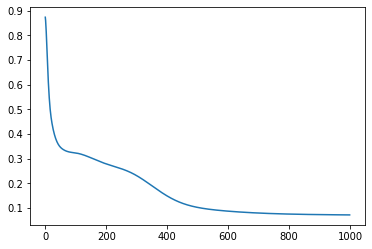

In [248]:
plt.plot(loss_hist)

### check train cycle 1

In [249]:
pred_train_1 = test_loop(md0, train_x, train_y, loss_fn)

loss: 0.213284 



Pred vs test data (normalized)

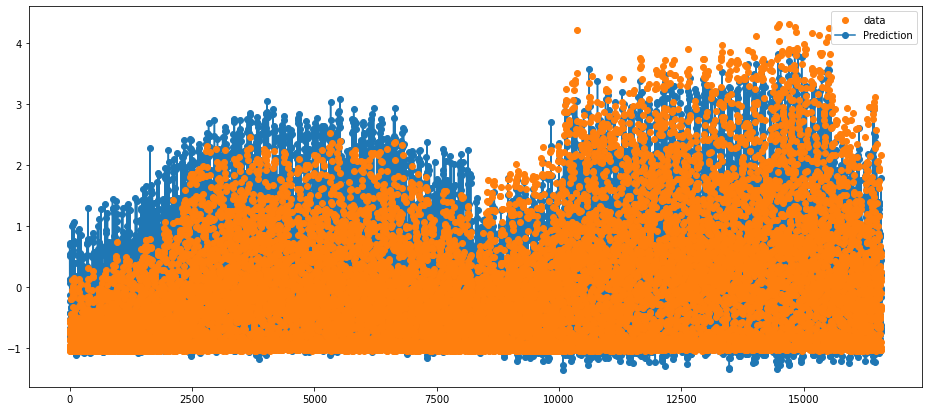

In [250]:
plt.figure(figsize = (16, 7))
#x_data = df_inp_test.reset_index()['index']
pred_data = pred_train_1.numpy()
tgt_data = train_y.numpy()
pred_plot, = plt.plot(pred_data, 'o-')
cnt_plot, = plt.plot(tgt_data, 'o')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

In [254]:
tgt_data_test = df2['cnt'][-21*24:].values

In [266]:
tgt_data_train = df2['cnt'][:-21*24].values

In [251]:
pred_test_1 = test_loop(md0, test_x, test_y, loss_fn)

loss: 0.186742 



In [252]:
pred_data_test_1 = pred_test_1.numpy() * feature_statistics['cnt'][1] + feature_statistics['cnt'][0]

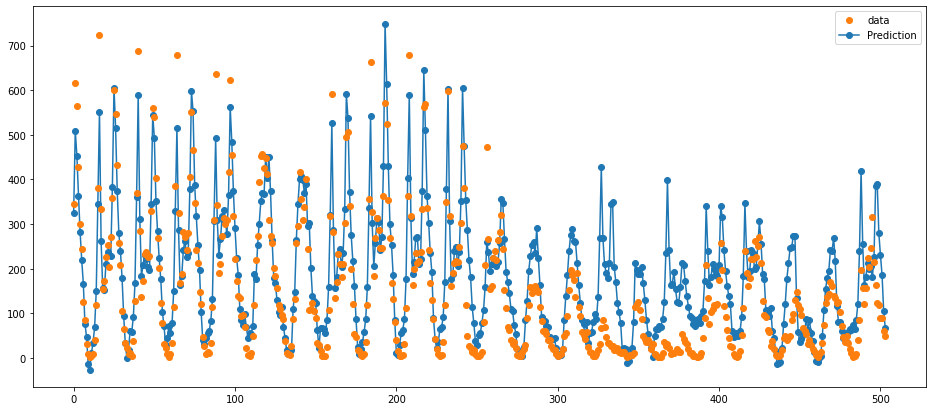

In [255]:
plt.figure(figsize = (16, 7))
#x_data = df_inp_test.reset_index()['index']
pred_plot, = plt.plot(pred_data_test_1, 'o-')
cnt_plot, = plt.plot(tgt_data_test, 'o')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

look not worse  than the "current data predictor"?

#### Train longer

In [257]:
loss_hist_2 = trn_epoches(10000, md0,loss_fn, train_dataloader,optimizer)

epoch      0/ 10000, loss: 0.071299
epoch    200/ 10000, loss: 0.069878
epoch    400/ 10000, loss: 0.069446
epoch    600/ 10000, loss: 0.069504
epoch    800/ 10000, loss: 0.067540
epoch   1000/ 10000, loss: 0.065283
epoch   1200/ 10000, loss: 0.063222
epoch   1400/ 10000, loss: 0.061449
epoch   1600/ 10000, loss: 0.059931
epoch   1800/ 10000, loss: 0.058608
epoch   2000/ 10000, loss: 0.057428
epoch   2200/ 10000, loss: 0.056356
epoch   2400/ 10000, loss: 0.055371
epoch   2600/ 10000, loss: 0.054461
epoch   2800/ 10000, loss: 0.053621
epoch   3000/ 10000, loss: 0.052848
epoch   3200/ 10000, loss: 0.052141
epoch   3400/ 10000, loss: 0.051500
epoch   3600/ 10000, loss: 0.050927
epoch   3800/ 10000, loss: 0.050422
epoch   4000/ 10000, loss: 0.049984
epoch   4200/ 10000, loss: 0.049613
epoch   4400/ 10000, loss: 0.049308
epoch   4600/ 10000, loss: 0.049065
epoch   4800/ 10000, loss: 0.048883
epoch   5000/ 10000, loss: 0.048756
epoch   5200/ 10000, loss: 0.048680
epoch   5400/ 10000, loss: 0

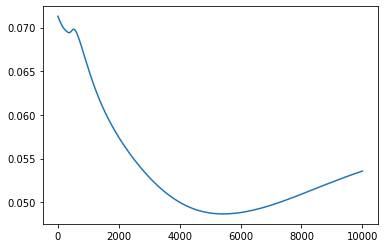

In [258]:
plt.plot(loss_hist_2)

In [259]:
pred_train_1 = test_loop(md0, train_x, train_y, loss_fn)

loss: 0.173536 



Pred vs test data (normalized)

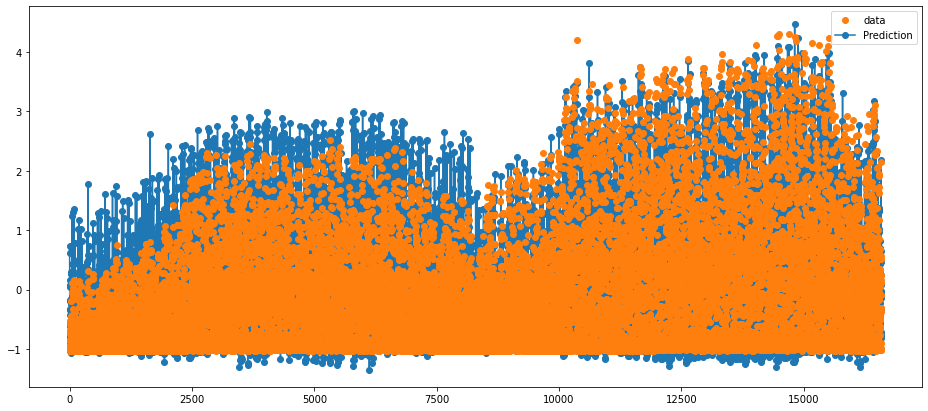

In [260]:
plt.figure(figsize = (16, 7))
#x_data = df_inp_test.reset_index()['index']
pred_data = pred_train_1.numpy()
tgt_data = train_y.numpy()
pred_plot, = plt.plot(pred_data, 'o-')
cnt_plot, = plt.plot(tgt_data, 'o')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

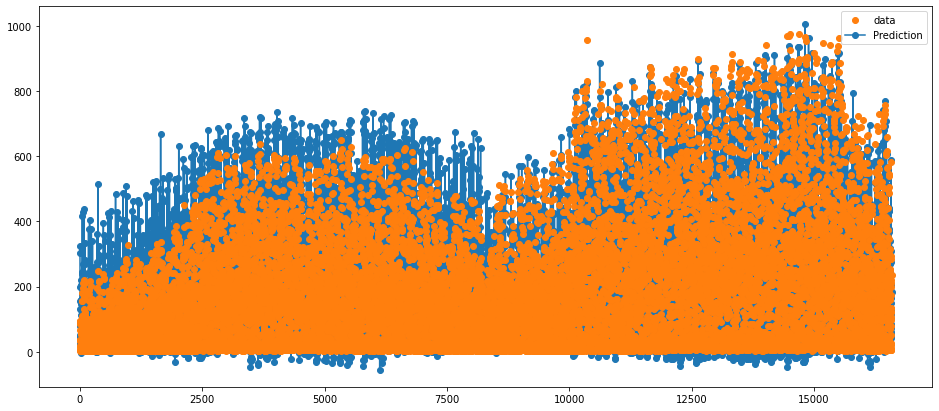

In [267]:
plt.figure(figsize = (16, 7))
pred_data = pred_train_1.numpy() * feature_statistics['cnt'][1] + feature_statistics['cnt'][0]
pred_plot, = plt.plot(pred_data, 'o-')
cnt_plot, = plt.plot(tgt_data_train, 'o')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

In [261]:
pred_test_1 = test_loop(md0, test_x, test_y, loss_fn)

loss: 0.135489 



In [262]:
pred_data_test_1 = pred_test_1.numpy() * feature_statistics['cnt'][1] + feature_statistics['cnt'][0]

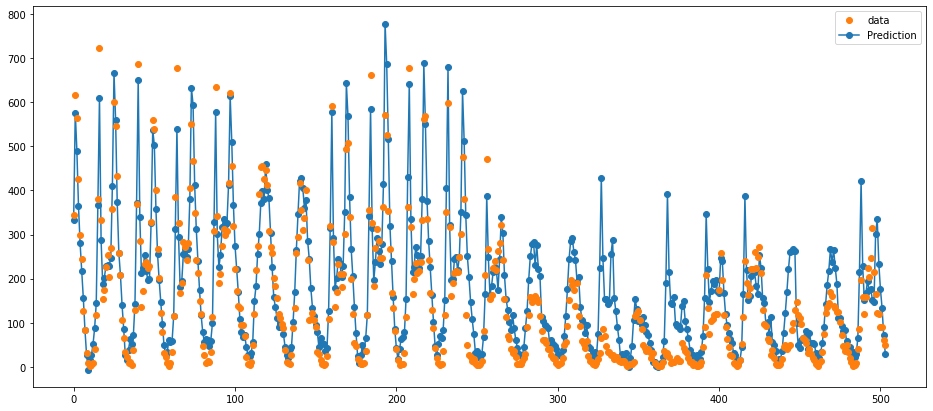

In [263]:
plt.figure(figsize = (16, 7))
#x_data = df_inp_test.reset_index()['index']
pred_plot, = plt.plot(pred_data_test_1, 'o-')
cnt_plot, = plt.plot(tgt_data_test, 'o')
plt.legend([cnt_plot, pred_plot],['data', 'Prediction'])
plt.show()

In [268]:
torch.save(md0.state_dict(), 'md0_m6_wts.pth')